# Nested Sampling with `dynesty`: Advanced Options

This is a simple interactive demo that outlines the various bounding and sampling options available to users in `dynesty`. This is meant to be a living document that will eventually get turned into documentation at some point in the future.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Target Distribution

To demonstrate more of the functionality afforded by our different sampling/bounding options we will demonstrate how these various features work using a set of 2-D **Gaussian shells** with a uniform prior over $[-6, 6]$.

In [4]:
# defining constants
r = 2.  # radius
w = 0.1  # width
c1 = np.array([-3.5, 0.])  # center of shell 1
c2 = np.array([3.5, 0.])  # center of shell 2
const = math.log(1. / math.sqrt(2. * math.pi * w**2))  # normalization constant

# log-likelihood of a single shell
def logcirc(theta, c):
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2)

# log-likelihood of two shells
def loglike(theta):
    return np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# our prior transform
def prior_transform(x):
    return 12. * x - 6.

In [5]:
# compute likelihood surface over a 2-D grid
xx, yy = np.meshgrid(np.linspace(-6., 6., 200), np.linspace(-6., 6., 200))
L = np.exp(loglike(np.dstack((xx, yy))))

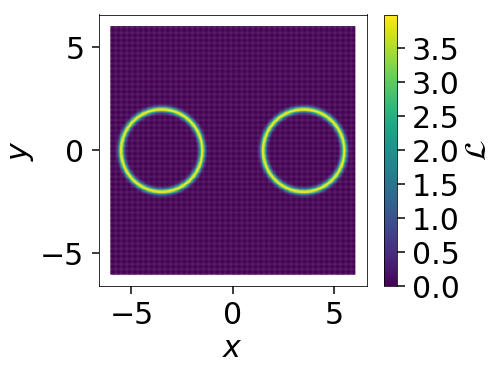

In [6]:
# plot result
fig = plt.figure(figsize=(6,5))
plt.scatter(xx, yy, c=L, s=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\mathcal{L}$');

# Bounding Options

`dynesty` supports a number of methods for bounding the target distribution:
- **No bound** (`'none'`), i.e. sampling from the entire unit cube. This is extremely inefficient but is a useful option to verify your results and look for possible biases. It otherwise should only be used if the log-likelihood is trivial to compute.
- A **single bounding ellipsoid** (`'single'`). This is the simplest bounding distribution that works well for simpler, uni-modal distributions.
- **Multiple** (possibly overlapping) **bounding ellipsoids** (`'multi'`). This is the **default option**. These are often flexible enough to capture the complexity of many likelihood distributions while simple enough to quickly and efficiently generate new samples.
- **Overlapping balls** centered on each live point (`'balls'`). These can generate more flexible bounding distributions but come with significantly more overhead. They are also less efficient at generating samples.
- **Overlapping cubes** centered on each live point (`'cubes'`). These serve as a more conservative alternative to `balls`.

Users can modify the specifics on all bounding objects using several keyword arguments. `'enlarge'` automatically enlarges all bounding object volumes by a specified fraction. If `bootstrap` is nonzero (default is 20), `'enlarge'` is determined by repeated bootstrap resampling from the set of live points. Otherwise, it defaults to 1.25. For `'multi'`, there are two additional keyword arguments `'vol_dec'` and `'vol_check'` which govern how aggressively to split bounding ellipsoids into multiple additional ellipsoids.

## Usage

Let's test out our bounding options (with uniform sampling) on these 2-D shells. To illustrate their baseline effectiveness, we will also disable the initial delay before our first update.

In [8]:
# bounding methods
bounds = ['none', 'single', 'multi', 'balls', 'cubes']

# run over each method and collect our results
bounds_res = []
for b in bounds:
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound=b, sample='unif', nlive=1000,
                                    first_update={'min_ncall': -np.inf,
                                                  'min_eff': np.inf})
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.1)
    t1 = time.time()
    res = sampler.results
    res['time'] = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('{0}s\n'.format(res['time']))
    bounds_res.append(sampler.results)

iter: 5494+1000 | nc: 1 | ncall: 251342 | eff(%):  2.584 | logz: -1.755 +/-  0.049 | dlogz:  0.000 <  0.100    
23.4850950241s
iter: 5491+1000 | nc: 1 | ncall: 107696 | eff(%):  6.027 | logz: -1.752 +/-  0.049 | dlogz:  0.000 <  0.100    
27.1950349808s
iter: 5563+1000 | nc: 1 | ncall: 26539 | eff(%): 24.730 | logz: -1.824 +/-  0.049 | dlogz:  0.000 <  0.100    
139.986950874s
iter: 5521+1000 | nc: 1 | ncall: 20761 | eff(%): 31.410 | logz: -1.782 +/-  0.049 | dlogz:  0.000 <  0.100    
272.697184086s
iter: 5534+1000 | nc: 1 | ncall: 22737 | eff(%): 28.737 | logz: -1.796 +/-  0.049 | dlogz:  0.000 <  0.100    
253.675657988s


We can see the amount of overhead associated with `'multi'`,`'cubes'`, and `'balls'` is non-trivial in this case. For `'multi'`, most of this overhead comes from the computational cost of *updating* our bounding distribution: multi-ellipsoidal decompositions are relatively expensive (especially given we repeat this process with bootstrap resampling to compute correction factors). For `'cubes'` and `'balls'`, on the other hand, the overhead mainly comes from *sampling* from our bouding distributions, since accepting or rejecting a point requires counting all neighbors within some radius $r$, leading to frequent nearest-neighbor searches. `dynesty` utilizes [KDTrees](https://en.wikipedia.org/wiki/K-d_tree) to help with these, adding some overhead but improving overall scaling.

Runtime aside, we see that each method runs for a similar number of iterations and give similar `logz` and `dlogz` values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln \mathcal{Z} = -1.75$).

## Visualizing Bounds

To get a sense of what each of our bounds looks like, we can use some of `dynesty`'s built-in plotting functionality.

In [9]:
from dynesty import plotting as dyplot

First, let's take a look at the case where we had no bounds (`'none'`). As we expect, the "bounding distribution" encompasses the entirety of the prior.

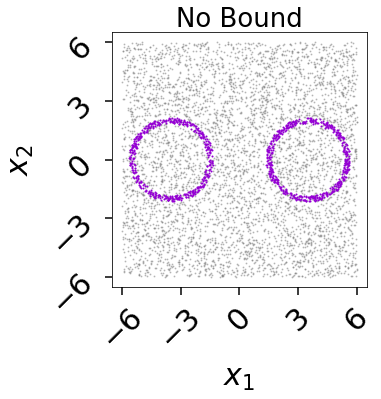

In [10]:
# initialize figure
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# plot proposals in corner format for 'none'
fg, ax = dyplot.cornerprop(bounds_res[0], it=3000, prior_transform=prior_transform,
                           show_live=True, fig=(fig, axes))
ax[0, 0].set_title('No Bound', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Now let's examine the single and multi-ellipsoidal cases. Here we can see one of the main benefits to multi-ellipsoidal decomposition: it is able to capture the shape of the distribution reasonably well while also tracking the two solutions separately.

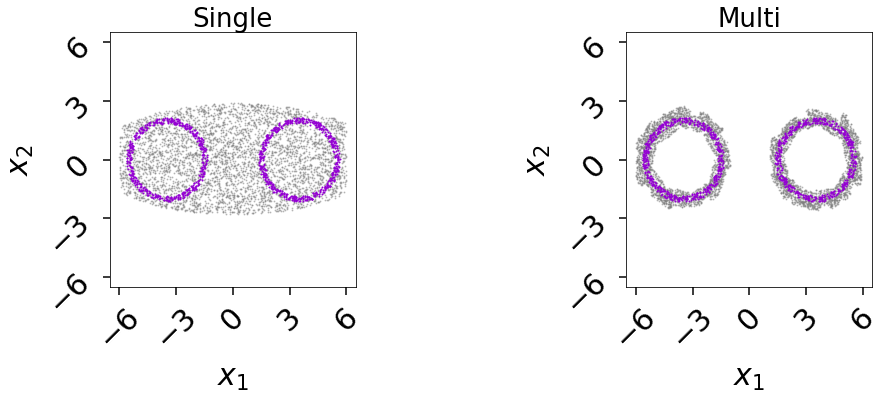

In [11]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'single'
fg, ax = dyplot.cornerprop(bounds_res[1], it=3000, prior_transform=prior_transform,
                           show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Single', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'multi'
fg, ax = dyplot.cornerprop(bounds_res[2], it=3000, prior_transform=prior_transform,
                           show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Multi', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Finally, let's take a look at our overlapping set of balls and cubes. Here we can see that these proposals offer the most flexible approximation to the shape of our shells and consequently the most efficient proposals in terms of raw number of likelihood calls.

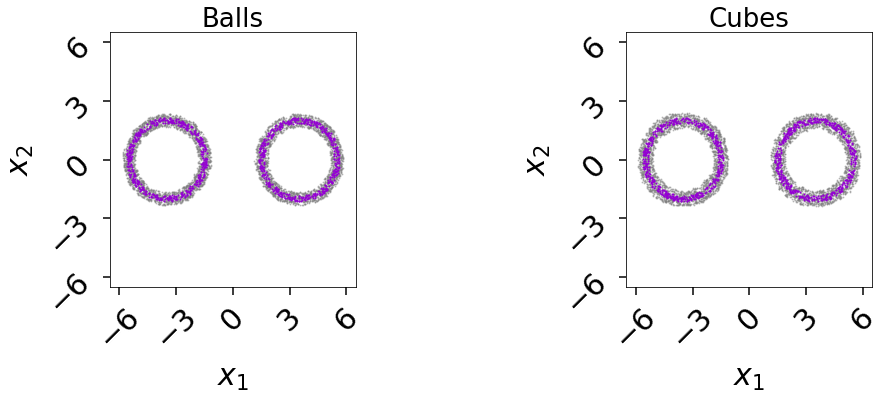

In [12]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'balls'
fg, ax = dyplot.cornerprop(bounds_res[3], it=3000, prior_transform=prior_transform,
                           show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Balls', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'cubes'
fg, ax = dyplot.cornerprop(bounds_res[4], it=3000, prior_transform=prior_transform,
                           show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Cubes', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

# Bounding Objects

By default, the nested samplers in `dynesty` save all bounding distributions used throughout the course of a run, which can be accessed within the `results` dictionary. More information on these distributions can be found in `bounding.py`.

In [13]:
# the proposals associated with our 'multi' bounds
bounds_res[2].prop

Each bounding object has a host of additional functionality that the user can experiment with. For instance, the volume contained by the *union* of ellipsoids within `MultiEllipsoid` can be estimated using **Monte Carlo integration** (but otherwise are not computed by default). These volume estimates, combined with what fraction of our samples overlap with the unit cube (since our bounding distributions can exceed our prior bounds), can give us an idea of how effectively our multi-ellipsoid bounds are shrinking over time compared with the single-ellipsoid case.

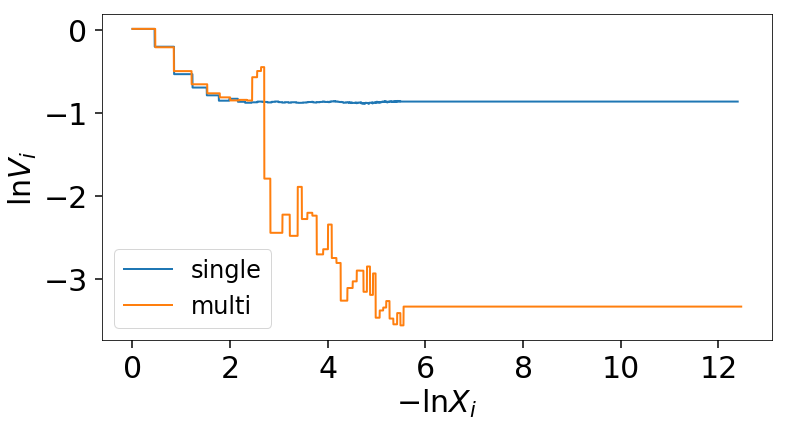

In [14]:
# grab effective 'single' volumes
single_vols = [1.]  # unit cube
for prop in bounds_res[1].prop[1:]:
    vol = prop.vol  # volume
    funit = prop.unitcube_overlap() # fractional overlap with unit cube
    single_vols.append(vol * funit)
single_vols = np.array(single_vols)

# compute effective 'multi' volumes
multi_vols = [1.]  # unit cube
for prop in bounds_res[2].prop[1:]:  # skip unit cube
    vol, funit = prop.monte_carlo_vol(return_overlap=True)
    multi_vols.append(vol * funit)  # numerical estimate via Monte Carlo methods
multi_vols = np.array(multi_vols)

# plot results as a function of ln(volume)
plt.figure(figsize=(12,6))
plt.xlabel(r'$-\ln X_i$')
plt.ylabel(r'$\ln V_i$')

# 'single'
res = bounds_res[1]
x = -res.logvol  # ln(prior volume)
it = res.prop_iter  # proposal idx at given iteration
y = np.log(single_vols[it])  # corresponding ln(bounding volume)
plt.plot(x, y, lw=2, label='single')

# 'multi'
res = bounds_res[2]
x, it = -res.logvol, res.prop_iter
y = np.log(multi_vols[it])
plt.plot(x, y, lw=2, label='multi')
plt.legend(loc='best', fontsize=24);

We see that in the beginning, only a single ellipsoid is used. After ~10 bounding updates have been made, there is enough of an incentive to split the proposal into several ellipsoids. Although the initial ellipsoid decompositions can be somewhat unstable (i.e. bootstrapping can give relatively large volume expansion factors), over time this process leads to a significant decrease in effective overall volume. The process by which an ellipsoid is split into multiple ellipsoids can be tuned by the user using the `'vol_dec'` and `'vol_check'` keyword arguments.

# Sampling Options

`dynesty` supports several different sampling methods conditioned on the bounding options described above:
- **Uniform** sampling (`'unif'`). This is the **default option**. In low dimensions ($d \lesssim 10$), uniform sampling within the bounds is generally more efficient at generating new live point proposals than alternative options (described below).
- **Random walks** away from a current live point (`'rwalk'`). This is the equivalent of running **Markov Chain Monte Carlo** (MCMC) over a bounded, uniform distribution where all proposals with $\mathcal{L}^* \geq \mathcal{L}_i$ are accepted. The implementation in `dynesty` proposes new positions based on the provided bounding distribution using a fixed number of walks (default is `'walks'=25`) with an additional scalefactor (`'scale'`) tuned to achieve 50% acceptance. In moderate dimensions ($d \sim 5-15$), random walks often are as efficient as uniform sampling.
- **Slice sampling** away from a current live point (`'slice'`). [Slice sampling](https://www.seas.harvard.edu/courses/cs281/papers/neal-2001.pdf) is a **non-rejection sampling technique** that draws samples from "slices" through the distribution. The multivariate implementation we use is akin to [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), where each complete "slice" involves rotating through each variable (in a random order) and sampling from the corresponding conditional distribution. To improve efficiency, an input bounding distribution can be used to determine a preferred orthogonal basis (and scale) to propose slices at each iteration. Several slices are often necessary to ensure fully independent samples, and by default `dynesty` uses `'slices'=3`. Slice sampling becomes more competitive in moderate-to-high dimensions ($d \gtrsim 20$).

## Usage

Let's test out our sampling options (with `'multi'` bounding) on our 2-D shells defined above.

In [14]:
# bounding methods
sampling = ['unif', 'rwalk', 'slice']

# run over each method and collect our results
sampling_res = []
for s in sampling:
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound='multi', sample=s, nlive=1000)
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.5)
    t1 = time.time()
    res = sampler.results
    res['time'] = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('{0}s\n'.format(res['time']))
    sampling_res.append(sampler.results)

iter: 4008+1000 | nc: 1 | ncall: 16453 | eff(%): 30.438 | logz: -1.705 +/-  0.037 | dlogz:  0.000 <  0.500    
51.1505019665s
iter: 3987+1000 | nc: 1 | ncall: 100675 | eff(%):  4.954 | logz: -1.685 +/-  0.037 | dlogz:  0.000 <  0.500    
242.308912039s
iter: 4119+1000 | nc: 1 | ncall: 127438 | eff(%):  4.017 | logz: -1.816 +/-  0.039 | dlogz:  0.000 <  0.500    
404.597539902s


As expected, uniform sampling in 2-D is substantially more efficient that other more complex alternatives. Regardless of runtime, however, we see that each method runs for a similar number of iterations and gives similar logz and dlogz values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln\mathcal{Z} = −1.75$).

## Visualizing Results

Nested sampling relies on live points being (mostly) independently and identically distributed (i.i.d.) to keep certain statistical properties intact. For MCMC, this is a (nominally) straightforward process where the resulting samples can be "thinned" by their auto-correlation lengthscale. Unfortunately, similar procedures are not easily available for nested sampling because new particle positions can be "evolved" from copies of random live points at a specific iteration (as with `'rwalk'` and `'slice'`) and samples cannot be trivially "thinned". As a result, such metrics (if desired) can only be computed "on the fly" during the actual run.

Trace plots, however, often serve as very effective qualitative diagnostics to identify correlated samples. As such, they remain invaluable tools for inspecting the results of a run. (While more formal tests to check nested sampling properties do exist, we will return to them later.) We show the traceplots for each sampling method below.

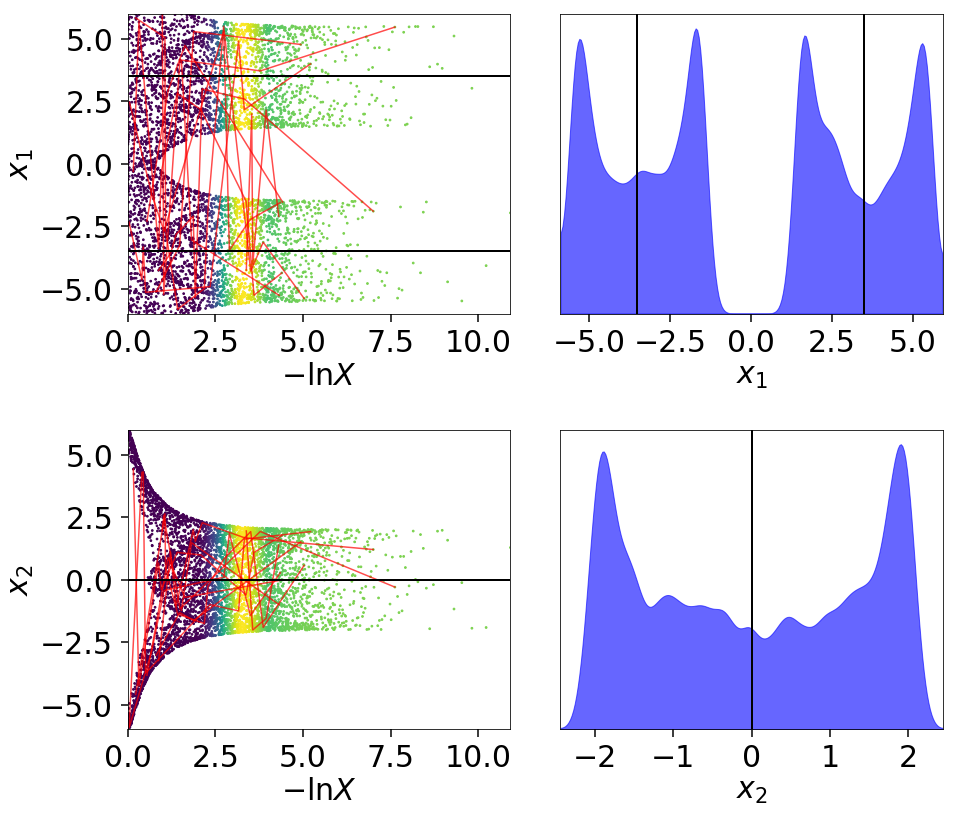

In [15]:
# plotting 'unif'
fig, axes = dyplot.traceplot(sampling_res[0], truths=np.c_[c1, c2], truth_color='black', quantiles=None,
                             trace_cmap='viridis',
                             connect=True, connect_highlight=10,
                             fig=plt.subplots(2, 2, figsize=(14, 12)))
fig.tight_layout()

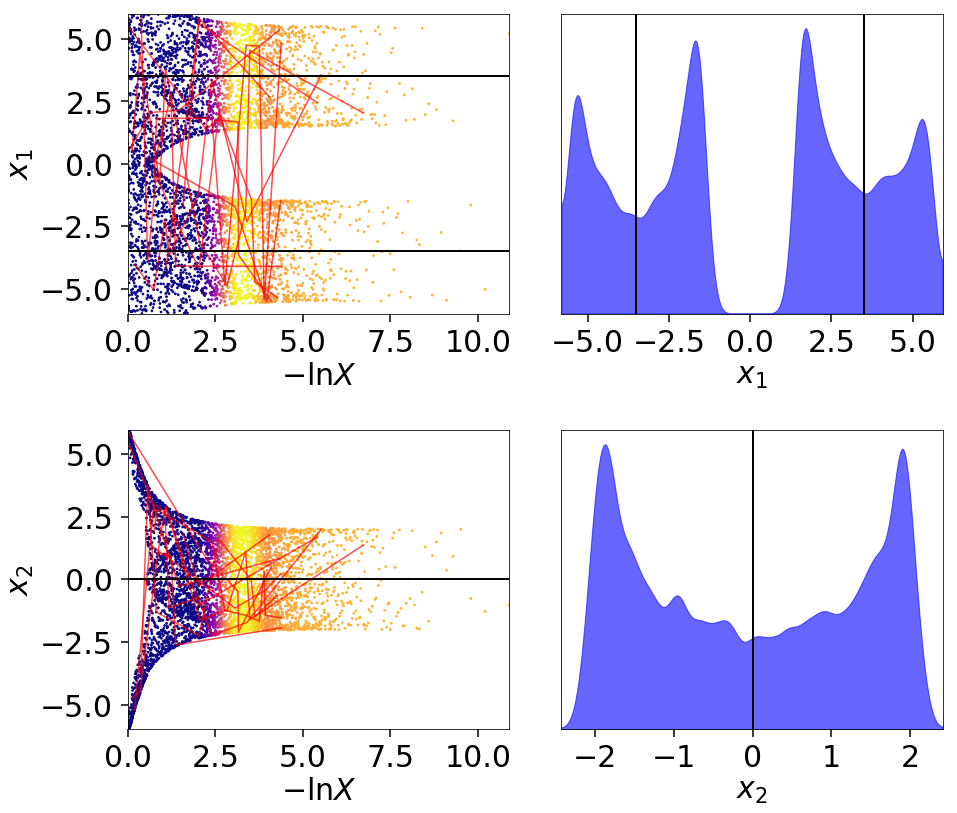

In [16]:
# plotting 'rwalk'
fig, axes = dyplot.traceplot(sampling_res[1], truths=np.c_[c1, c2], truth_color='black', quantiles=None,
                             trace_cmap='plasma',
                             connect=True, connect_highlight=10,
                             fig=plt.subplots(2, 2, figsize=(14, 12)))
fig.tight_layout()

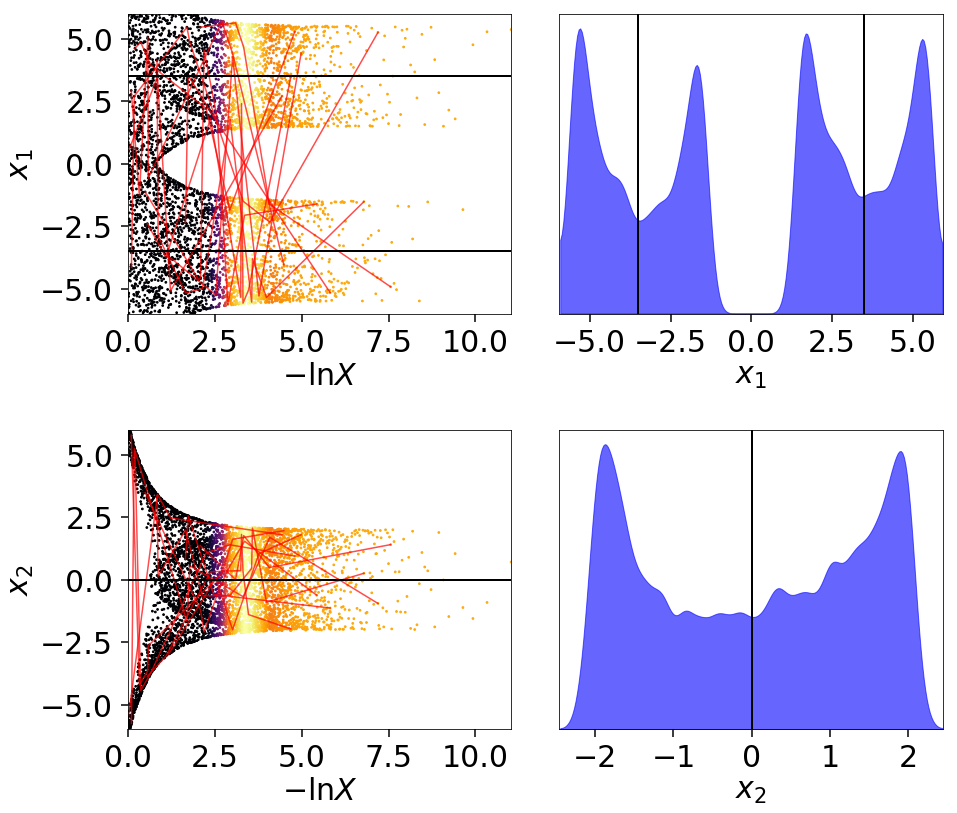

In [17]:
# plotting 'slice'
fig, axes = dyplot.traceplot(sampling_res[2], truths=np.c_[c1, c2], truth_color='black', quantiles=None,
                             trace_cmap='inferno',
                             connect=True, connect_highlight=10,
                             fig=plt.subplots(2, 2, figsize=(14, 12)))
fig.tight_layout()

We see that our samples appear well mixed in all cases, without any obvious biases or suspicious features.

# Bootstrapping Tests and Dimensional Scaling

One of the largest overheads associated with nested sampling is the time needed to propose new bounding distributions. To avoid bounding distributions that fail to properly encompass the remaining likelihood, `dynesty` automatically expands the volume of all bounding distributions by an enlargement factor (`'enlarge'`). By default, this factor is determined in real time using **bootstrapping** following the scheme outlined in [Buchner 2014](https://arxiv.org/abs/1407.5459)) but defaults to 1.25 otherwise.

While bootstrapping is highly recommended, there are some instances where it might be desireable to disable it. For instance, slice sampling (and to a lesser extent random walks) incorporate additional tuning that makes them less sensitive to the absolute scale of the bounding distributions. In addition, bootstrapping often can lead to massive volume expansion factors in moderate-to-high dimensions since volume scales as $\propto r^d$. *While these factors are often justified*, they can drastically reduce the raw sampling efficiency when sampling uniformly by causing a large number of proposed samples to fall outside the unit cube (leading to automatic rejection).

We showcase this behavior below by illustrating the performance of our `NestedSampler` on several $N-D$ Gaussian shells with and without bootstrapping.

In [18]:
# setup for running tests over gaussian shells in arbitrary dimensions
nlive = 1000
def run(ndim, bootstrap, bound, method, update):
    """Convenience function for running in any dimension."""

    c1 = np.zeros(ndim)
    c1[0] = -3.5
    c2 = np.zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))
    sampler = dynesty.NestedSampler(f, prior_transform, ndim=ndim, update=update,
                                    bound=bound, sample=method, nlive=nlive, 
                                    **{'bootstrap': bootstrap})
    sampler.run_nested(dlogz=0.5)
    
    return sampler.results

In [19]:
# analytic ln(evidence) values
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09}

# compute results for N-D Gaussian shells
results = []
for ndim in [2, 5, 10]:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 20, 'multi', 'unif', 0.6)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results.append(res)

# results without bootstrapping
results2 = []
for ndim in [2, 5, 10, 20]:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'unif', 0.6)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results2.append(res)

iter: 4105+1000 | nc: 1 | ncall: 15966 | eff(%): 31.974 | logz: -1.801 +/-  0.039 | dlogz:  0.000 <  0.500    
55.6113059521s
iter: 7912+1000 | nc: 1 | ncall: 22336 | eff(%): 39.900 | logz: -5.608 +/-  0.073 | dlogz:  0.000 <  0.500    
56.4142119884s
iter: 16569+1000 | nc: 1 | ncall: 69661 | eff(%): 25.221 | logz: -14.265 +/-  0.119 | dlogz:  0.000 <  0.500    
188.437872887s
iter: 4117+1000 | nc: 1 | ncall: 12095 | eff(%): 42.307 | logz: -1.814 +/-  0.039 | dlogz:  0.000 <  0.500    
5.08252501488s
iter: 7998+1000 | nc: 1 | ncall: 24601 | eff(%): 36.576 | logz: -5.695 +/-  0.074 | dlogz:  0.000 <  0.500    
10.4717669487s
iter: 16830+1000 | nc: 1 | ncall: 50714 | eff(%): 35.158 | logz: -14.526 +/-  0.120 | dlogz:  0.000 <  0.500    
20.7625641823s
iter: 38009+1000 | nc: 1 | ncall: 185359 | eff(%): 21.045 | logz: -35.709 +/-  0.190 | dlogz:  0.000 <  0.500    
96.36855793s


In [20]:
print('With bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in zip([2, 5, 10], results):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))
print('\n')
print('Without bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in zip([2, 5, 10, 20], results2):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))

With bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.80     0.04   15966   31.97   55.61
 5    -5.67   -5.61     0.07   22336   39.90   56.41
10   -14.59  -14.26     0.12   69661   25.22  188.44


Without bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.81     0.04   12095   42.31    5.08
 5    -5.67   -5.70     0.07   24601   36.58   10.47
10   -14.59  -14.53     0.12   50714   35.16   20.76
20   -36.09  -35.71     0.19  185359   21.05   96.37


While our results are comparable between both cases, in higher dimensions multi-ellipsoid bounding distributions often are over-constrained and have a habit of "shrinking" too quickly, leading to biased results. Slice sampling mitigates this problem by sampling *conditioned* on the ellipsoid axes, and so only depends on ellipsoid shapes, not sizes.

In [21]:
# adding on slice sampling
results3 = []
for ndim in [2, 5, 10, 20]:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'slice', 0.6 * ndim)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results3.append(res)

iter: 3982+1000 | nc: 1 | ncall: 122980 | eff(%):  4.051 | logz: -1.679 +/-  0.037 | dlogz:  0.000 <  0.500    
13.6185128689s
iter: 7998+1000 | nc: 1 | ncall: 606477 | eff(%):  1.484 | logz: -5.694 +/-  0.074 | dlogz:  0.000 <  0.500    
61.7875459194s
iter: 14094 | nc: 159 | ncall: 2129566 | eff(%):  0.662 | logz: -29.418 +/-  0.125 | dlogz: 16.729 >  0.500    dynesty/bounding.py:342: RuntimeWarning: overflow encountered in double_scalars
  self.expand_tot *= vol_tot / self.vol_tot
iter: 17017+1000 | nc: 1 | ncall: 2574343 | eff(%):  0.700 | logz: -14.712 +/-  0.121 | dlogz:  0.000 <  0.500    
309.815914154s
iter: 38404+1000 | nc: 1 | ncall: 11633693 | eff(%):  0.339 | logz: -36.101 +/-  0.191 | dlogz:  0.000 <  0.500    
1145.03886604s


In [22]:
print('Slice sampling without bootstrapping:')
print("D  analytic    logz  logzerr    nlike   eff(%)   time")
for ndim, res in zip([2, 5, 10, 20], results3):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:8d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))

Slice sampling without bootstrapping:
D  analytic    logz  logzerr    nlike   eff(%)   time
 2    -1.75   -1.68     0.04    122980    4.05   13.62
 5    -5.67   -5.69     0.07    606477    1.48   61.79
10   -14.59  -14.71     0.12   2574343    0.70  309.82
20   -36.09  -36.10     0.19  11633693    0.34  1145.04


# Performance in High Dimensions

As mentioned earlier, `dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems. Here we will quickly demonstrate that slice sampling scales relatively well to high-dimensional problems (efficiency "only" goes as $\propto 1/D$) using a 50-D highly correlated multivariate normal distribution.

In [23]:
ndim = 50  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

In [24]:
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update=5.*ndim,
                                bound='single', sample='slice', nlive=500,
                                **{'bootstrap': 0})
sampler.run_nested(dlogz=0.001, save_proposals=False)
hdres = sampler.results

iter: 86879+500 | nc: 1 | ncall: 65939676 | eff(%):  0.133 | logz: -149.799 +/-  0.547 | dlogz:  0.000 <  0.001     


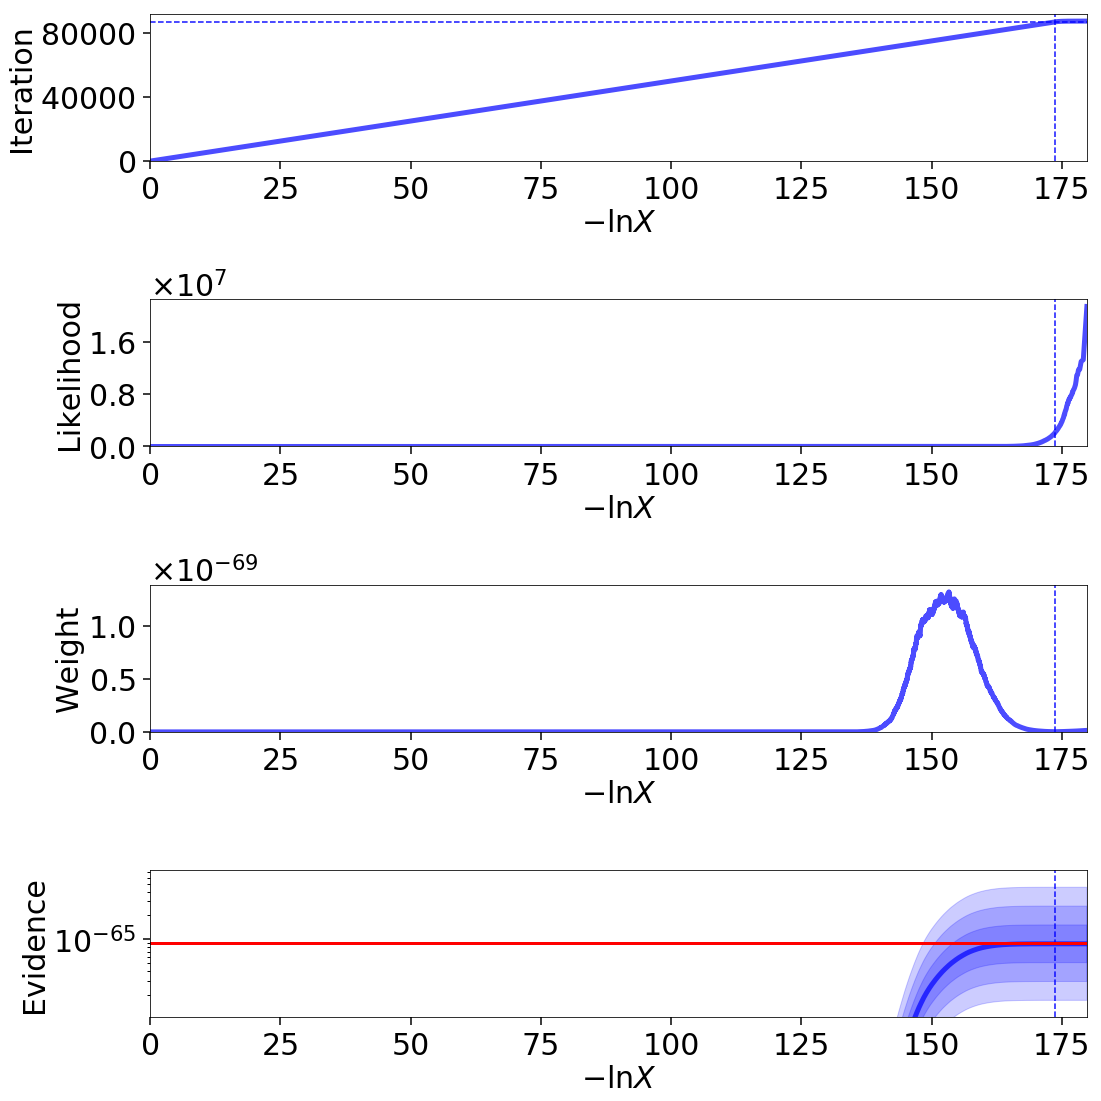

In [25]:
lnz_truth = -ndim * np.log(20.)
fig, axes = dyplot.runplot(hdres, color='blue', lnz_truth=lnz_truth, logplot=True)
fig.tight_layout()

# Summary

`dynesty` contains a host of options that allows users a large degree of control over how to sample from their target distributions. In addition, many of the components of dynesty (such as bounding objects) are well-documented and can be manipulated. Users are encouraged to experiment to see what options work best for their particular problem.